#### Cost-Effective Personalized Policies for Implementing Organ-at-Risk Sparing Adaptive Radiation Therapy in Head and Neck Cancer
Copyright (c) 2024 Daniel Suarez Aguirre \&  Seyedmohammadhossein Hosseinian. All rights reserved.
### Simulations

In [1]:
#uncomment if not installed
#!pip install pymdptoolbox
#!pip uninstall matplotlib
#!pip install matplotlib==3.7.3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mdptoolbox.mdp import ValueIteration

In [2]:
# Parameters
## Time Horizon
T = 5

##5-year survival rate 
S_values = {'overall': 0.685,
     'HPV+': 0.80,
     'HPV-': 0.40}

cancer_knowledge = 'overall'
#cancer_knowledge = 'HPV+'
#cancer_knowledge = 'HPV-'

S = S_values[cancer_knowledge]


## Quality of Life factor
Q_values = {'conservative':0.80,
    'xerostomia':0.85,
    'dysphagia':0.827
    }

side_effect = 'conservative'
#side_effect = 'xerostomia'
#side_effect = 'dysphagia'

Q = Q_values[side_effect]

## set discount factor
discount_factor = 0.99999

##set seed
np.random.seed(13)



In [3]:
# helper function for reading data files
def load_csv_with_bom(file_path):
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        return np.loadtxt(f, delimiter=',')
# Load Transition Probabilities
prob_F0010 = load_csv_with_bom('data/prob_F0010.csv')
prob_DN = load_csv_with_bom('data/prob_DN.csv')
prob_F1015_RP = load_csv_with_bom('data/prob_F1015_RP.csv')
prob_F1520_RP = load_csv_with_bom('data/prob_F1520_RP.csv')
prob_F2025_RP = load_csv_with_bom('data/prob_F2025_RP.csv')
prob_F2530_RP = load_csv_with_bom('data/prob_F2530_RP.csv')


In [4]:
# Modular Function for MDP setting 
# Change in QALY from \delta NTCP
def QALY_gains(Q, T, S, delta_NTCP: float):
    delta_QALY = T * S * delta_NTCP * (1 - Q)
    return delta_QALY

# monetary value of health benefit
def health_benefit(Q, T, S, delta_NTCP, W):
    delta_QALY = QALY_gains(Q, T, S, delta_NTCP)
    return W * delta_QALY

# Set probabilities and rewards for the MDP
def probabilities_and_rewards(Q, S, T, W, C):
    #Rewards
    rew_F0010_DN = np.zeros(13)
    rew_F0010_RP = -1_000_000 * np.ones(13) #large number because one cannot replan at this stage

    #for F1015, F1520, F2025 reward is cost of action
    rew_F1015_DN = np.zeros((13,13))
    rew_F1520_DN = np.zeros((13,13))
    rew_F2025_DN = np.zeros((13,13))

    rew_F1015_RP = -C * np.ones((13,13))
    rew_F1520_RP = -C * np.ones((13,13))
    rew_F2025_RP = -C * np.ones((13,13))

    #for F2530 the reward is the health benefit of each final state delta_NTCP and the cost of action
    health_benefits = np.array(range(13)) #benefits for each final state delta_NTCP
    for i in range(13):
        health_benefits[i] = health_benefit(Q, T, S, - i/100, W) 

    rew_F2530_DN = np.zeros((13,13))
    rew_F2530_RP = np.zeros((13,13))
    for i in range(13):
        rew_F2530_DN[i,:] = health_benefits
        rew_F2530_RP[i,:] = health_benefits - C 


    #States
    States = ["F0-0%",
            "F10-0%", "F10-1%", "F10-2%", "F10-3%", "F10-4%", "F10-5%", "F10-6%",
            "F10-7%", "F10-8%", "F10-9%", "F10-10%", "F10-11%", "F10-12%",
            "F15-0%", "F15-1%", "F15-2%", "F15-3%", "F15-4%", "F15-5%", "F15-6%",
            "F15-7%", "F15-8%", "F15-9%", "F15-10%", "F15-11%", "F15-12%",
            "F20-0%", "F20-1%", "F20-2%", "F20-3%", "F20-4%", "F20-5%", "F20-6%",
            "F20-7%", "F20-8%", "F20-9%", "F20-10%", "F20-11%", "F20-12%",
            "F25-0%", "F25-1%", "F25-2%", "F25-3%", "F25-4%", "F25-5%", "F25-6%",
            "F25-7%", "F25-8%", "F25-9%", "F25-10%", "F25-11%", "F25-12%",
            "F30-0%", "F30-1%", "F30-2%", "F30-3%", "F30-4%", "F30-5%",
            "F30-6%", "F30-7%", "F30-8%", "F30-9%", "F30-10%", "F30-11%", "F30-12%",
            "F_end"]

    #Number of states
    N = 67

    # Initialize P and R
    P = np.zeros((2, N, N))
    R = np.zeros((2, N, N))

    # F00 
    P[0, 0, 1:14] = prob_F0010
    P[1, 0, 1:14] = prob_F0010
    R[0, 0, 1:14] = rew_F0010_DN
    R[1, 0, 1:14] = rew_F0010_RP

    #F10
    P[0, 1:14, 14:27] = prob_DN
    P[1, 1:14, 14:27] = prob_F1015_RP
    R[0, 1:14, 14:27] = rew_F1015_DN
    R[1, 1:14, 14:27] = rew_F1015_RP

    # F15
    P[0, 14:27, 27:40] = prob_DN
    P[1, 14:27, 27:40] = prob_F1520_RP
    R[0, 14:27, 27:40] = rew_F1520_DN
    R[1, 14:27, 27:40] = rew_F1520_RP

    # F20
    P[0, 27:40, 40:53] = prob_DN
    P[1, 27:40, 40:53] = prob_F2025_RP
    R[0, 27:40, 40:53] = rew_F2025_DN
    R[1, 27:40, 40:53] = rew_F2025_RP

    # F25
    P[0, 40:53, 53:66] = prob_DN
    P[1, 40:53, 53:66] = prob_F2530_RP
    R[0, 40:53, 53:66] = rew_F2530_DN
    R[1, 40:53, 53:66] = rew_F2530_RP

    # F30
    P[0, 53:66, 66:67] = np.ones((13, 1)) 
    P[1, 53:66, 66:67] = np.ones((13, 1)) 
    R[0, 53:66, 66:67] = np.zeros((13, 1)) 
    R[1, 53:66, 66:67] = -C * np.ones((13,1))

    #F_end
    P[0, 66, 66] = 1. 
    P[1, 66, 66] = 1. 
    R[0, 66, 66] = 0.
    R[1, 66, 66] = -C #unfeasible to replan at this stage, negative value ensures that replanning is not chosen

    return P, R, N, States

# solve MDP using Value Iteration
def solve_MDP_vi(P, R, discount_factor):
    # Initialize value iteration solver
    vi = ValueIteration(P, R, discount_factor)
    # Run the solver
    vi.run()
    # Extract the optimal policy
    policy = vi.policy
    values = vi.V
    return policy, values

# Run 
def Cost_Effective_ART_MDP_run(Q,S,T,W,C):
    P, R, N, States = probabilities_and_rewards(Q, S, T, W, C)
    policy, values = solve_MDP_vi(P, R, discount_factor)
    return policy, values

In [5]:
#functions to simulate run
def policy_transtion_matrix(policy, P):
    N = P.shape[1]
    P_policy = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            P_policy[i,j] = P[int(policy[i]), i, j]
    return P_policy


def next_state(state, transition_prob_matrix):
    random = np.random.random()
    transition_probs = transition_prob_matrix[state,:]
    next_state = 0
    prob_sum = transition_probs[0]
    while random > prob_sum:
        next_state += 1
        prob_sum += transition_probs[next_state]
    return next_state


def simulate_run(policy, P, T = 5):
    N = P.shape[1]
    state = 0
    states = [state]
    for t in range(T):
        transition_prob_matrix = policy_transtion_matrix(policy, P)
        state = next_state(state, transition_prob_matrix)
        states.append(state)
    return states


def check_states(run):
    val = True
    if run[0] != 0:
        val = False
    if run[1] not in range(1,14):
        val = False
    if run[2] not in range(14,27):
        val = False
    if run[3] not in range(27,40):
        val = False
    if run[4] not in range(40,53):
        val = False
    if run[5] not in range(53,66):
        val = False
    return val


def count_replans(policy, run, T = 5):
    replans = 0
    for i in range(0,T+1):
        replans += policy[run[i]]
    return replans


def run_to_delta_NTCP(run):
    delta_NTCP_run = [0]
    for state in run[1:]:
        delta_NTCP = ((state - 1) % 13)
        delta_NTCP_run.append(delta_NTCP)
    return delta_NTCP_run

In [6]:
# helper functions to show results
def display_policy(policy, optimal = False):
    if optimal: print("Optimal Policy:")
    else: print("Policy:")
    print('F00:', policy[0])
    print('F10:', policy[1:14])
    print('F15:', policy[14:27])
    print('F20:', policy[27:40])
    print('F25:', policy[40:53])
    print('F30:', policy[53:66])
    print('F_end:', policy[66])


def policy_to_array(policy):
    policy_array = np.zeros((4, 13))
    policy_array[0,:] = policy[1:14]
    policy_array[1,:] = policy[14:27]
    policy_array[2,:] = policy[27:40]
    policy_array[3,:] = policy[40:53]
    return policy_array


def policy_to_tresholds(policy):
    epochs = [10, 15, 20, 25]
    policy_array = policy_to_array(policy)
    tresholds = []
    for epoch in epochs:
        index_max = np.argmax(policy_array[epochs.index(epoch)])
        if policy_array[epochs.index(epoch)][index_max] == 0:
            tresholds.append(99)
        else:
            tresholds.append(index_max)
    return tresholds


def tresholds_to_policy(tresholds):
    policy = np.zeros(67)
    count = 0 
    for treshold in tresholds:
        if treshold > 12:
            count += 1
            continue
        policy[count*13 + treshold + 1 : (count+1)*13 + 1] = 1
        count += 1
    
    policy.astype(int)
    return policy

In [7]:
# run simulations
def run_simulations(policy, P, n = 10000):
    np.random.seed(0)
    replans = []
    final_delta_NTCP = []

    for i in range(n):
        run = simulate_run(policy, P)
        if not check_states(run):
            print("Error in run", run)
            break
        replans.append(count_replans(policy, run))
        delta_NTCP = run_to_delta_NTCP(run)
        final_delta_NTCP.append(delta_NTCP[-1])

    return replans, final_delta_NTCP 

In [8]:
# plot results
def plot_replans(replans,title):
    plt.figure(figsize=(10, 6))
    sns.histplot(replans, bins = 5, discrete= True)
    counts, bins = np.histogram(replans, bins=5, range=(0,5))
    for count, bin_pos in zip(counts, bins[:-1]):
        if count != 0:
            plt.text(bin_pos, count, str(count), ha='center', va='bottom')
    plt.title('Replans Distribution')
    plt.xlabel('Number of Replans')
    plt.ylabel(f'Frequency (#runs = {len(replans)})')
    plt.savefig(f'dist_#replans_{title}.png')


def plot_final_delta_NTCP(final_delta_NTCP, title):
    plt.figure(figsize=(10, 6))
    sns.histplot(final_delta_NTCP, bins = np.arange(13), discrete = True)
    counts, bins = np.histogram(final_delta_NTCP, bins=13)
    spq=0
    for count, bin_pos in zip(counts, bins[:-1]):
        spq+=1
        if count != 0:
            plt.text(bin_pos + spq*(bins[1]-bins[0])/20, count, str(count), ha='center', va='bottom', 
                     rotation=45)
    plt.title('End-treatment \u0394NTCP (%) Distribution')
    plt.xlabel('End-treatment \u0394NTCP (%)')
    plt.ylabel(f'Frequency (#runs = {len(final_delta_NTCP)})')
    plt.xlim(-0.5, 12)
    plt.ylim(-0.5, 5000)
    plt.xticks(range(13))
    #plt.savefig(f'dist_NTCP_{title}.png')
    plt.show()

## MC Simulation

**Specify willingness to pay per QALY and cost per replan, e.g., W = 200,000 USD and C = 1,000 USD.**

In [9]:
# set W, C 
W = 200_000
C = 1_000
# get probabilities and rewards
P, R, N, States = probabilities_and_rewards(Q, S, T, W, C)

Optimal Policy:
F00: 0
F10: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F20: (0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1)
F25: (0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1)
F30: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
F_end: 0

 Running Simulation...

W = $200000
C = $1000

Mean Replans: 0.3831
Mean End-treatment ΔNTCP: 0.9772 %


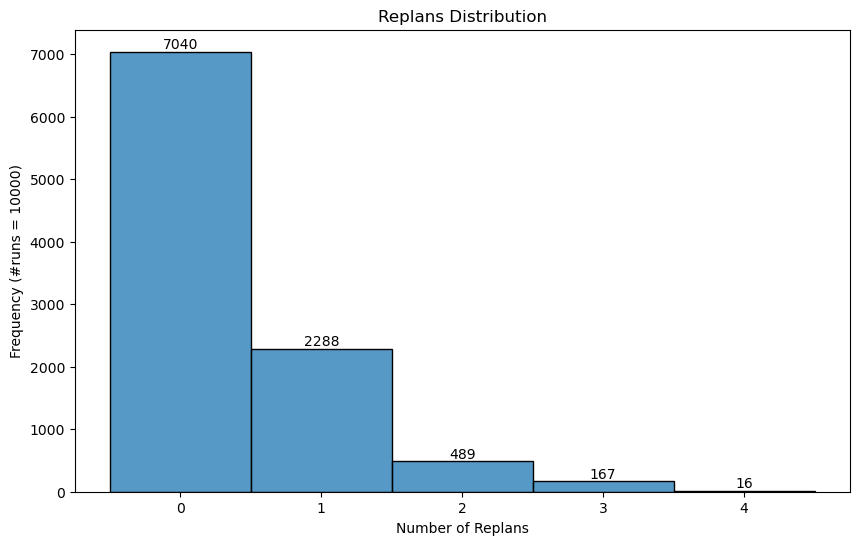

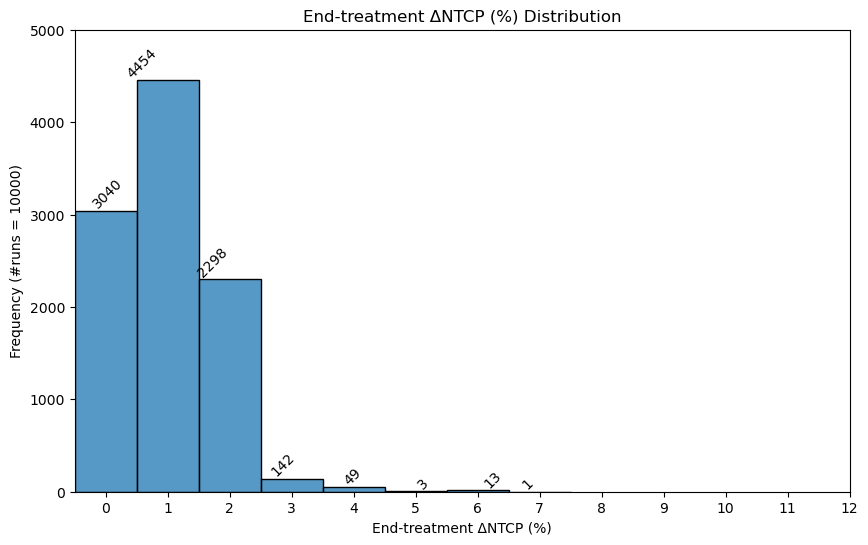

In [10]:
# get optimal policy 
policy_opt, values = solve_MDP_vi(P, R, discount_factor)

#display policy
display_policy(policy_opt, optimal = True)
tresholds_opt = policy_to_tresholds(policy_opt)

# simulate optimal policy outcomes
print('\n Running Simulation...\n')
print(f'W = ${W}')
print(f'C = ${C}\n')
replans_opt, final_delta_NTCP_opt = run_simulations(policy_opt, P, n = 10_000)

print(f'Mean Replans: {np.mean(replans_opt)}')
print(f'Mean End-treatment ΔNTCP: {np.mean(final_delta_NTCP_opt)} %')

plot_replans(replans_opt,'opt')
plot_final_delta_NTCP(final_delta_NTCP_opt,'opt')

Policy:
F00: 0.0
F10: [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F15: [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F20: [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F25: [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0

 Running Simulation...

W = $200000
C = $1000

Mean Replans: 0.3842
Mean End-treatment ΔNTCP: 0.977


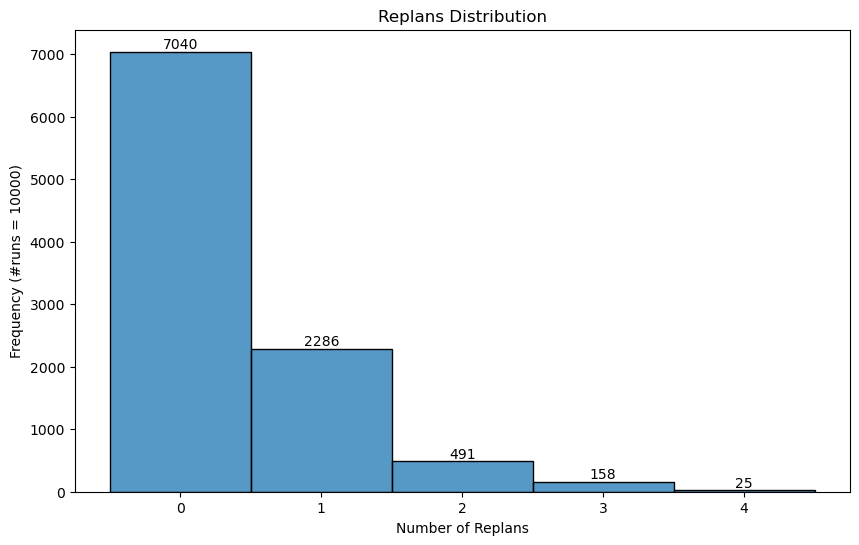

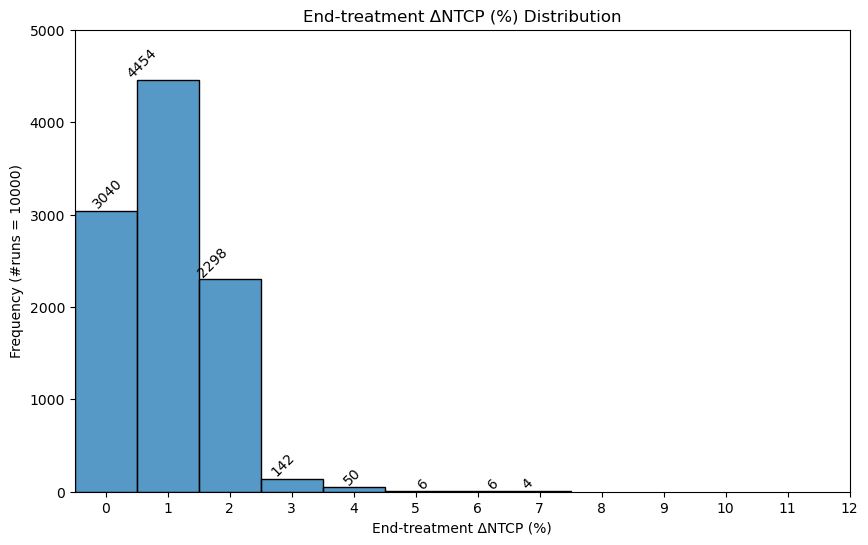

In [11]:
# treshholded policy
policy_opt_tresh = tresholds_to_policy(tresholds_opt)

# display policy
display_policy(policy_opt_tresh, optimal = False)

# simulate tresholded policy outcomes
print('\n Running Simulation...\n')
print(f'W = ${W}')
print(f'C = ${C}\n')
replans_opt_tresh, final_delta_NTCP_opt_tresh = run_simulations(policy_opt_tresh, P, n = 10000)

print(f'Mean Replans: {np.mean(replans_opt_tresh)}')
print(f'Mean End-treatment ΔNTCP: {np.mean(final_delta_NTCP_opt_tresh)}')

plot_replans(replans_opt_tresh,'opt_tresh')
plot_final_delta_NTCP(final_delta_NTCP_opt_tresh,'opt_tresh')

Policy:
F00: 0.0
F10: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F15: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F20: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F25: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0

 Running Simulation...

W = $200000
C = $1000

Mean Replans: 1.0
Mean End-treatment ΔNTCP: 1.1979


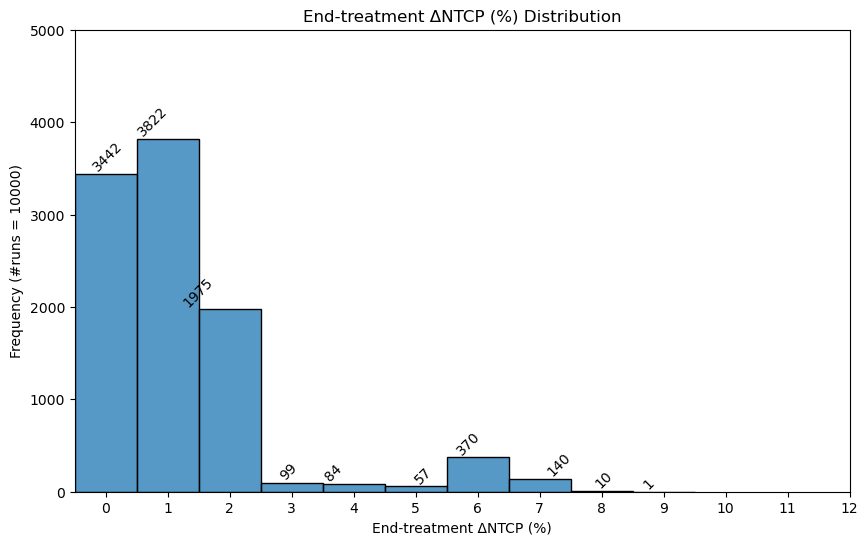

In [12]:
# policy with single replan at F10
policy_sr10 = tresholds_to_policy([0, 99, 99, 99])

# display policy
display_policy(policy_sr10, optimal = False)

# simulate policy outcomes
print('\n Running Simulation...\n')
print(f'W = ${W}')
print(f'C = ${C}\n')
replans_sr10, final_delta_NTCP_sr10 = run_simulations(policy_sr10, P, n = 10000)

print(f'Mean Replans: {np.mean(replans_sr10)}')
print(f'Mean End-treatment ΔNTCP: {np.mean(final_delta_NTCP_sr10)}')

plot_final_delta_NTCP(final_delta_NTCP_sr10,'F10')

Policy:
F00: 0.0
F10: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F15: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F20: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F25: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0

 Running Simulation...

W = $200000
C = $1000

Mean Replans: 1.0
Mean End-treatment ΔNTCP: 1.5696


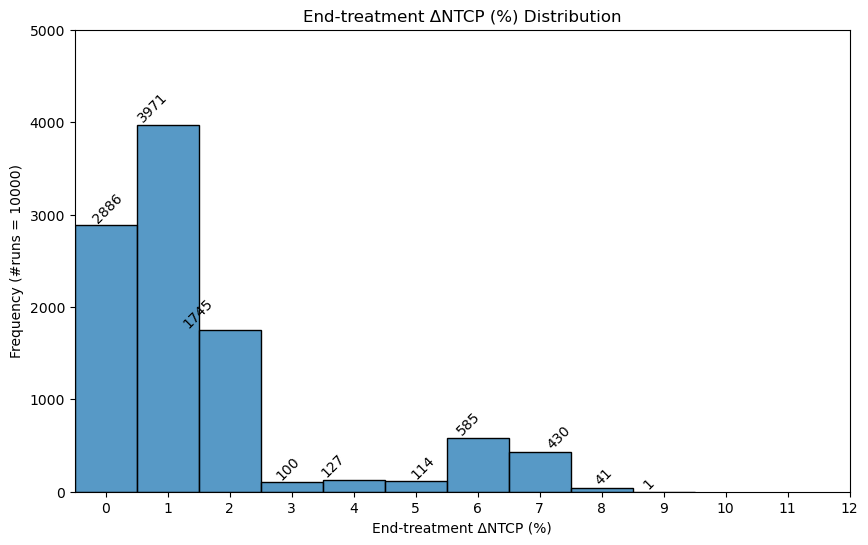

In [13]:
# policy with single replan at F15
policy_sr15 = tresholds_to_policy([99, 0, 99, 99])

# display policy
display_policy(policy_sr15, optimal = False)

# simulate single replan at F15 policy outcomes
print('\n Running Simulation...\n')
print(f'W = ${W}')
print(f'C = ${C}\n')
replans_sr15, final_delta_NTCP_sr15 = run_simulations(policy_sr15, P, n = 10000)

print(f'Mean Replans: {np.mean(replans_sr15)}')
print(f'Mean End-treatment ΔNTCP: {np.mean(final_delta_NTCP_sr15)}')

plot_final_delta_NTCP(final_delta_NTCP_sr15,'F15')

Policy:
F00: 0.0
F10: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F15: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F20: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F25: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0

 Running Simulation...

W = $200000
C = $1000

Mean Replans: 1.0
Mean End-treatment ΔNTCP: 1.8156


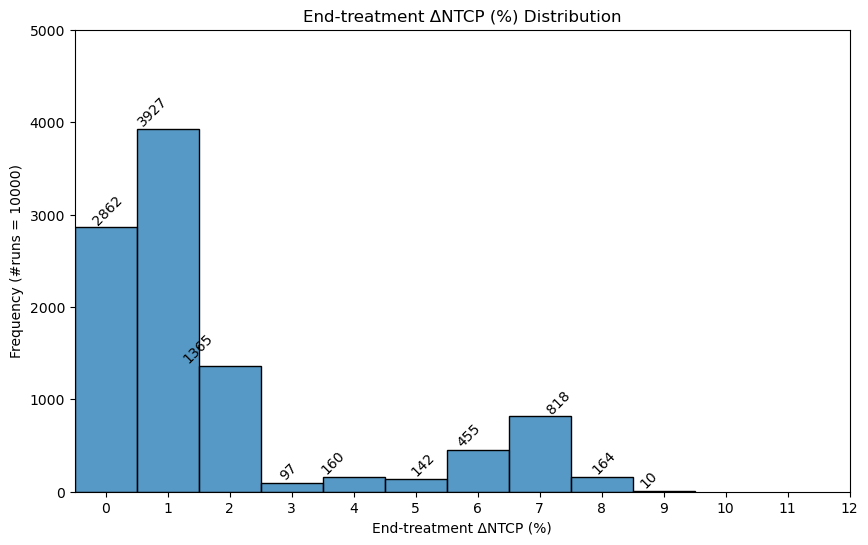

In [14]:
# policy with single replan at F20
policy_sr20 = tresholds_to_policy([99, 99, 0, 99])

# display policy
display_policy(policy_sr20, optimal = False)

# simulate policy outcomes
print('\n Running Simulation...\n')
print(f'W = ${W}')
print(f'C = ${C}\n')
replans_sr20, final_delta_NTCP_sr20 = run_simulations(policy_sr20, P, n = 10000)

print(f'Mean Replans: {np.mean(replans_sr20)}')
print(f'Mean End-treatment ΔNTCP: {np.mean(final_delta_NTCP_sr20)}')

plot_final_delta_NTCP(final_delta_NTCP_sr20,'F20')

Policy:
F00: 0.0
F10: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F15: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F20: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F25: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0

 Running Simulation...

W = $200000
C = $1000

Mean Replans: 1.0
Mean End-treatment ΔNTCP: 2.119


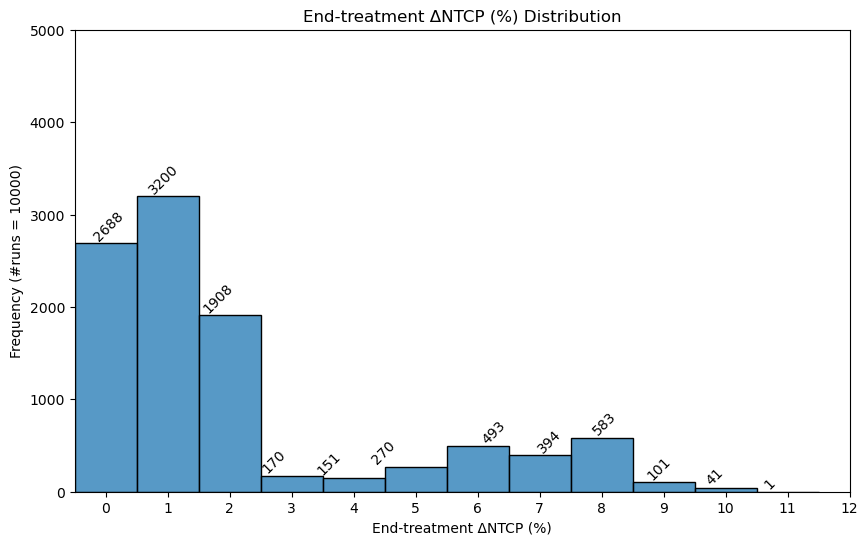

In [15]:
# policy with single replan at F25
policy_sr25 = tresholds_to_policy([99, 99, 99, 0])

# display policy
display_policy(policy_sr25, optimal = False)

# simulate policy outcomes
print('\n Running Simulation...\n')
print(f'W = ${W}')
print(f'C = ${C}\n')
replans_sr25, final_delta_NTCP_sr25 = run_simulations(policy_sr25, P, n = 10000)

print(f'Mean Replans: {np.mean(replans_sr25)}')
print(f'Mean End-treatment ΔNTCP: {np.mean(final_delta_NTCP_sr25)}')

plot_final_delta_NTCP(final_delta_NTCP_sr25,'F25')

Policy:
F00: 0.0
F10: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F15: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F20: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F25: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0

 Running Simulation...

W = $200000
C = $1000

Mean Replans: 0.0
Mean End-treatment ΔNTCP: 2.3618


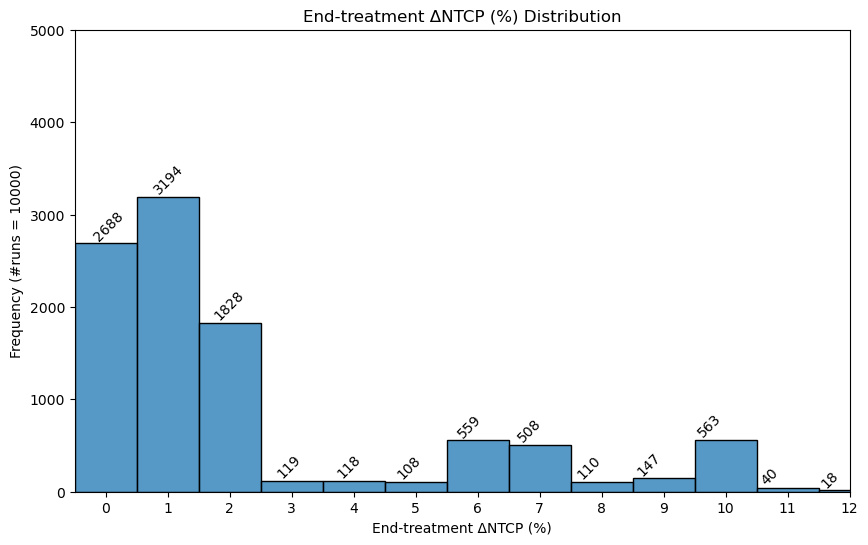

In [16]:
# policy with no replan
policy_dn = tresholds_to_policy([99, 99, 99, 99])

# display policy and tresholds
display_policy(policy_dn, optimal = False)

# simulate policy outcomes
print('\n Running Simulation...\n')
print(f'W = ${W}')
print(f'C = ${C}\n')
replans_dn, final_delta_NTCP_dn = run_simulations(policy_dn, P, n = 10000)

print(f'Mean Replans: {np.mean(replans_dn)}')
print(f'Mean End-treatment ΔNTCP: {np.mean(final_delta_NTCP_dn)}')

plot_final_delta_NTCP(final_delta_NTCP_dn,'DN')